In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TEST-ONLINE-577.png
/kaggle/input/fundus-pytorch/val/0/REFUGE1-train-211.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-823.png
/kaggle/input/fundus-pytorch/val/0/PAPILA-387.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2843.png
/kaggle/input/fundus-pytorch/val/0/REFUGE1-val-102.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2249.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TEST-ONLINE-866.png
/kaggle/input/fundus-pytorch/val/0/BEH-373.png
/kaggle/input/fundus-pytorch/val/0/G1020-230.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2437.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-1805.png
/kaggle/input/fundus-pytorch/val/0/JSIEC-1000-10.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-655.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-285.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR-TRAIN-2346.png
/kaggle/input/fundus-pytorch/val/0/FIVES-252.png
/kaggle/input/fundus-pytorch/val/0/OIA-ODIR

In [2]:
# Basic data manipulations
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
! pip install torchsummary
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score, classification_report
import seaborn as sns

In [3]:
train_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
train_path = '/kaggle/input/fundus-pytorch/train'
folder_list = os.listdir(train_path)
label_map = {
    "0":"Glaucoma Present", 
    "1":"Glaucoma not Present",
}
for folder in label_map:
    img_path = os.path.join(train_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)
train_df[["class_id"]] = train_df[["class_id"]].astype(int)



In [4]:
val_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
val_path = '/kaggle/input/fundus-pytorch/val'
for folder in label_map:
    img_path = os.path.join(val_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)
val_df[["class_id"]] = val_df[["class_id"]].astype(int)

In [5]:
test_df = pd.DataFrame({"path":[],"label":[], "class_id":[]})
test_path = '/kaggle/input/fundus-pytorch/test'
for folder in label_map:
    img_path = os.path.join(test_path, folder)
    jpg_list = glob(img_path+'/*.png')
    for jpg in jpg_list:
        new_data =pd.DataFrame({"path":jpg,"label":label_map[folder], "class_id":folder}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)
test_df[["class_id"]] = test_df[["class_id"]].astype(int)

In [6]:
train_df.head()

,path,label,class_id
0,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0
1,/kaggle/input/fundus-pytorch/train/0/REFUGE1-t...,Glaucoma Present,0
2,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0
3,/kaggle/input/fundus-pytorch/train/0/PAPILA-38...,Glaucoma Present,0
4,/kaggle/input/fundus-pytorch/train/0/OIA-ODIR-...,Glaucoma Present,0


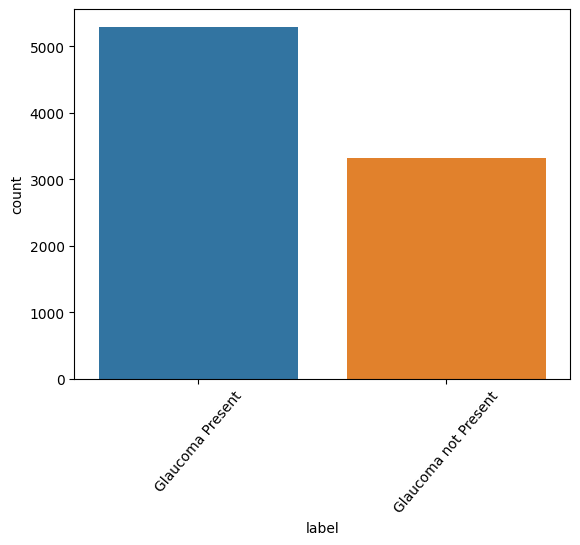

In [7]:
sns.countplot(x = train_df["label"])
plt.xticks(rotation = 50);

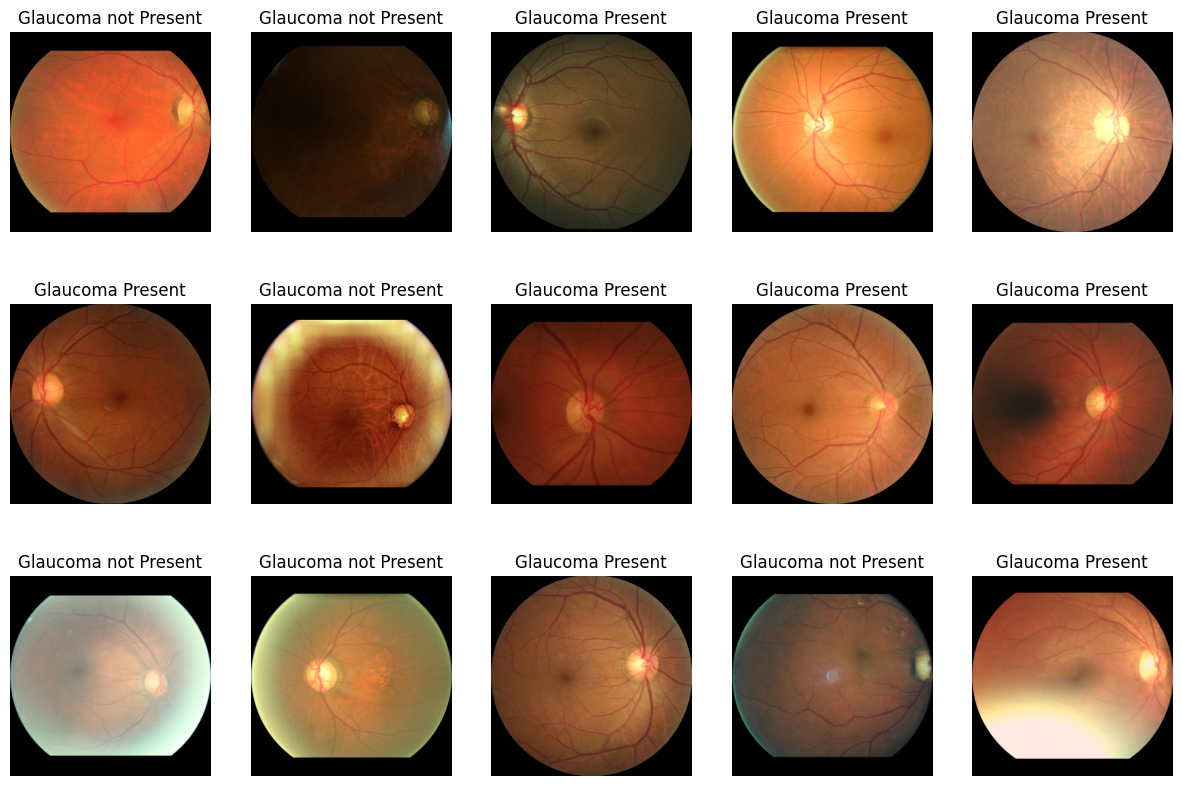

In [8]:
show_imgs = 15
idx = np.random.randint(0, len(train_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = train_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(train_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [9]:
train_transforms = v2.Compose([
    v2.Resize(256),
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    # v2.RandomRotation(degrees=(-20, 20)),
    v2.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    v2.RandomErasing(p=0.5, scale=(0.1,0.15)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

])

test_transforms = v2.Compose([
    v2.Resize((224,224)),
    v2.PILToTensor(),
    v2.ToDtype(torch.float32),
    v2.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [10]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transforms_):
        self.df = dataframe
        # We'll use transforms for data augmentation and converting PIL images to torch tensors.
        self.transforms_ = transforms_
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = self.df.iloc[index]['path']
        # img = Image.open(image_path).convert("LA")
        img = Image.open(image_path).convert("RGB")
        # img = Image.open(image_path)
        transformed_img = self.transforms_(img)
        class_id = self.df.iloc[index]['class_id']
        return transformed_img, class_id

In [11]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
num_workers = 2 if device=='cuda' else 4 # fixed by kaggle notebook
train_dataset = MyDataset(train_df, train_transforms)
val_dataset = MyDataset(val_df, test_transforms)
test_dataset = MyDataset(test_df, test_transforms)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [12]:
print(f'train data:{len(train_df)}')
print(f'val data:{len(val_df)}')

train data:8621
val data:5747


In [13]:
model = models.mobilenet_v3_large(pretrained=True)
num_features = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_features, 2)
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 146MB/s]


MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

In [14]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0 
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        
        # First we'll clean the cache of optimizer
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(data_)
        
        # Computing loss 
        loss = loss_fn(outputs,target_)
        
        # Backward propagation
        loss.backward()
        
        # Optimizing model
        optimizer.step()
        
        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0 
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)
            
            # Computing loss 
            loss = loss_fn(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [15]:
model.to(device)
EPOCHS = 25

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

if os.path.exists('checkpoints') == False:
    os.mkdir("checkpoints")
    
criterion  = nn.CrossEntropyLoss()


# Optimizer which will use gradients to train model.
learning_rate = 0.0001
momentum = 0.9
weight_decay = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0007)
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Earlystopping
patience = 3
counter = 0
best_loss = np.inf

best_model_path = "/kaggle/working/best_model.pth"  # Define the path where you want to save the best model

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(val_loader, model, criterion)
    print(f'EPOCH: {epoch} \
    train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} \
    val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} \
    Learning Rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)
    torch.save(model.state_dtict(), "checkpoints/last.pth")

    # Check for improvement in validation loss
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), best_model_path)  # Save the best model
    else:
        counter += 1
    if counter >= patience:
        print("Earlystop!")
        break

# Load the best model before evaluating
model.load_state_dict(torch.load(best_model_path))

  4%|▍         | 1/25 [05:22<2:08:49, 322.05s/it]

EPOCH: 0     train_loss: 0.5039, train_acc: 0.754     val_loss: 0.3618, val_acc: 0.837     Learning Rate: 0.0001


  8%|▊         | 2/25 [09:14<1:43:20, 269.57s/it]

EPOCH: 1     train_loss: 0.4270, train_acc: 0.800     val_loss: 0.3111, val_acc: 0.863     Learning Rate: 0.0001


 12%|█▏        | 3/25 [13:09<1:32:56, 253.47s/it]

EPOCH: 2     train_loss: 0.3942, train_acc: 0.816     val_loss: 0.2844, val_acc: 0.875     Learning Rate: 0.0001


 16%|█▌        | 4/25 [17:04<1:26:15, 246.44s/it]

EPOCH: 3     train_loss: 0.3686, train_acc: 0.834     val_loss: 0.2896, val_acc: 0.870     Learning Rate: 0.0001


 20%|██        | 5/25 [21:01<1:20:58, 242.92s/it]

EPOCH: 4     train_loss: 0.3620, train_acc: 0.837     val_loss: 0.2782, val_acc: 0.880     Learning Rate: 0.0001


 24%|██▍       | 6/25 [24:57<1:16:09, 240.52s/it]

EPOCH: 5     train_loss: 0.3583, train_acc: 0.840     val_loss: 0.2577, val_acc: 0.887     Learning Rate: 0.0001


 28%|██▊       | 7/25 [28:51<1:11:32, 238.45s/it]

EPOCH: 6     train_loss: 0.3410, train_acc: 0.850     val_loss: 0.2595, val_acc: 0.890     Learning Rate: 1e-05


 32%|███▏      | 8/25 [32:48<1:07:23, 237.83s/it]

EPOCH: 7     train_loss: 0.3199, train_acc: 0.861     val_loss: 0.2416, val_acc: 0.894     Learning Rate: 1e-05


 36%|███▌      | 9/25 [36:42<1:03:06, 236.66s/it]

EPOCH: 8     train_loss: 0.3162, train_acc: 0.862     val_loss: 0.2382, val_acc: 0.895     Learning Rate: 1e-05


 40%|████      | 10/25 [40:36<59:00, 236.01s/it] 

EPOCH: 9     train_loss: 0.3102, train_acc: 0.862     val_loss: 0.2262, val_acc: 0.900     Learning Rate: 1e-05


 44%|████▍     | 11/25 [44:31<55:00, 235.75s/it]

EPOCH: 10     train_loss: 0.3113, train_acc: 0.864     val_loss: 0.2267, val_acc: 0.900     Learning Rate: 1e-05


 48%|████▊     | 12/25 [48:26<51:02, 235.54s/it]

EPOCH: 11     train_loss: 0.3021, train_acc: 0.868     val_loss: 0.2213, val_acc: 0.904     Learning Rate: 1e-05


 52%|█████▏    | 13/25 [52:22<47:07, 235.59s/it]

EPOCH: 12     train_loss: 0.3032, train_acc: 0.866     val_loss: 0.2201, val_acc: 0.903     Learning Rate: 1e-05


 56%|█████▌    | 14/25 [56:19<43:14, 235.83s/it]

EPOCH: 13     train_loss: 0.3073, train_acc: 0.862     val_loss: 0.2208, val_acc: 0.904     Learning Rate: 1.0000000000000002e-06


 60%|██████    | 15/25 [1:00:13<39:13, 235.38s/it]

EPOCH: 14     train_loss: 0.3029, train_acc: 0.864     val_loss: 0.2222, val_acc: 0.902     Learning Rate: 1.0000000000000002e-06


 64%|██████▍   | 16/25 [1:04:08<35:18, 235.40s/it]

EPOCH: 15     train_loss: 0.2972, train_acc: 0.871     val_loss: 0.2200, val_acc: 0.903     Learning Rate: 1.0000000000000002e-06


 68%|██████▊   | 17/25 [1:08:04<31:23, 235.48s/it]

EPOCH: 16     train_loss: 0.2961, train_acc: 0.871     val_loss: 0.2197, val_acc: 0.903     Learning Rate: 1.0000000000000002e-06


 72%|███████▏  | 18/25 [1:12:00<27:29, 235.57s/it]

EPOCH: 17     train_loss: 0.2998, train_acc: 0.865     val_loss: 0.2194, val_acc: 0.904     Learning Rate: 1.0000000000000002e-06


 76%|███████▌  | 19/25 [1:15:55<23:32, 235.49s/it]

EPOCH: 18     train_loss: 0.2995, train_acc: 0.869     val_loss: 0.2201, val_acc: 0.903     Learning Rate: 1.0000000000000002e-06


 80%|████████  | 20/25 [1:19:52<19:40, 236.05s/it]

EPOCH: 19     train_loss: 0.2960, train_acc: 0.872     val_loss: 0.2194, val_acc: 0.904     Learning Rate: 1.0000000000000002e-06


 80%|████████  | 20/25 [1:23:45<20:56, 251.27s/it]

EPOCH: 20     train_loss: 0.3019, train_acc: 0.869     val_loss: 0.2199, val_acc: 0.903     Learning Rate: 1.0000000000000002e-07
Earlystop!


<All keys matched successfully>

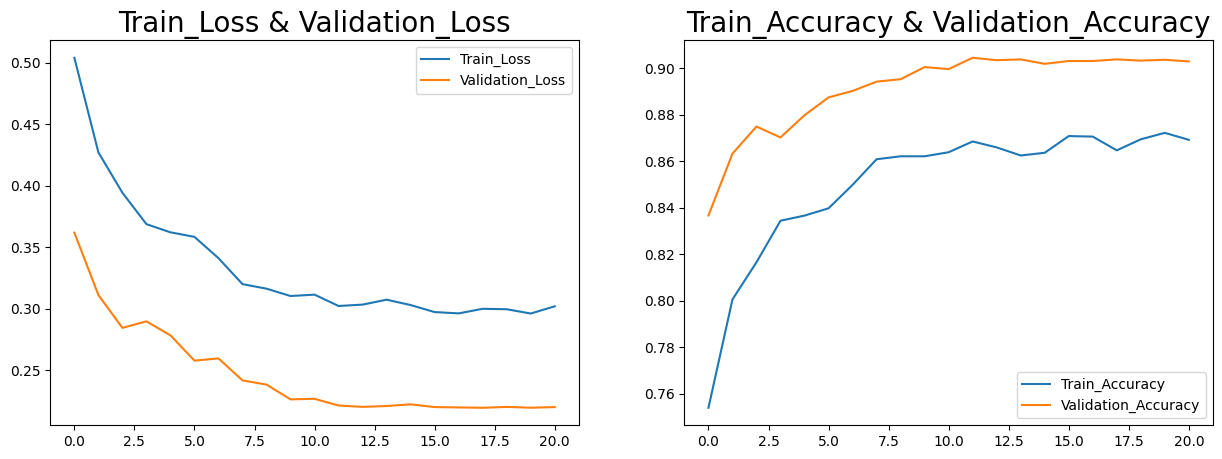

In [16]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(logs['train_loss'],label='Train_Loss')
plt.plot(logs['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(logs['train_acc'],label='Train_Accuracy')
plt.plot(logs['val_acc'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [17]:
model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for (data_,target_) in tqdm(test_loader):
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)
        outputs = model(data_)
        _,pred = torch.max(outputs,dim=1)
        y_true.extend(target_.cpu().numpy())
        y_pred.extend(pred.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)


100%|██████████| 90/90 [01:00<00:00,  1.48it/s]


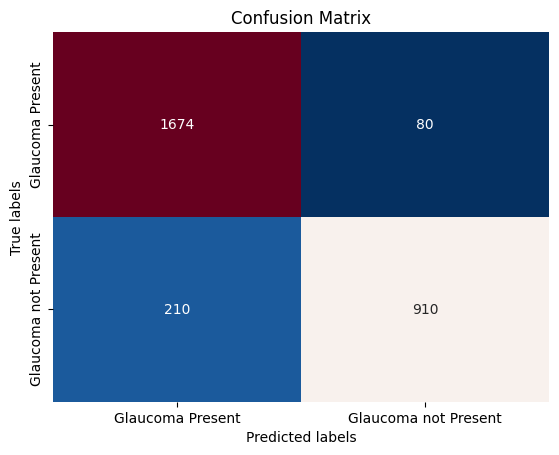

In [18]:
label_list = ["Glaucoma Present", "Glaucoma not Present"]
ax= plt.subplot()
CM = confusion_matrix(y_true,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax, cbar=False,cmap='RdBu_r',
            xticklabels= label_list, yticklabels=label_list)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
plt.show()

In [19]:
clf_report = classification_report(y_true, y_pred, target_names = label_list)
print(clf_report)

                      precision    recall  f1-score   support

    Glaucoma Present       0.89      0.95      0.92      1754
Glaucoma not Present       0.92      0.81      0.86      1120

            accuracy                           0.90      2874
           macro avg       0.90      0.88      0.89      2874
        weighted avg       0.90      0.90      0.90      2874

